In [2]:
# data cleaning

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

df = pd.read_csv('dataset/marketing_campaign.csv', sep="\t")

df.isnull().sum() * 100 / len(df)

print("Размер датафрейма:", df.shape)

print("Названия столбцов: \n", df.columns)

print('Процент нулевых значений: ', df.isnull().sum() * 100 / len(df))

df = df.dropna()
df = df.drop_duplicates()
print("Количество строк после удаления пропущенных значений и дубликатов:", len(df))

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
print('Дата регистрации первого клиента: ', df.Dt_Customer.min())
print('Дата регистрации последнего клиента: ', df.Dt_Customer.max())

df['first_day'] = '01-01-2015'
df['first_day'] = pd.to_datetime(df.first_day)
df['Day_engaged'] = (df['first_day'] - df['Dt_Customer']).dt.days

df["Age"] = 2022-df["Year_Birth"]

df['Marital_Status'].unique()

df["Living_Status"]=df["Marital_Status"].replace({"Married":"Family", "Together":"Family",
                                                  "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone",
                                                  "Divorced":"Alone", "Single":"Alone"})

df['Education'].unique()

df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate",
                                         "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Total_Accepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['Total_Purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

df.apply(pd.Series.nunique)

col_to_drop = ['Year_Birth', 'Marital_Status', 'ID', 'Kidhome', 'Teenhome', 'Dt_Customer', 'first_day',
               'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df.drop(col_to_drop, inplace = True, axis=1)



'''
Найдем неинформативные признаки, у которых более 95% строк содержат одно и то же значение
'''
num_rows = len(df.index)
low_information_cols = []
for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

df['Z_CostContact'].unique()
df['Z_Revenue'].unique()

#Данные признаки имеют единственное значение, соответственно не важны при построении модели
df = df.drop(['Z_CostContact','Z_Revenue'],axis = 1)

Размер датафрейма: (2240, 29)
Названия столбцов: 
 Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')
Процент нулевых значений:  ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 1.071429
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts   

Удаленные признаки: ['MntWines', 'NumCatalogPurchases', 'NumStorePurchases', 'Expenses', 'Total_Purchases'] 



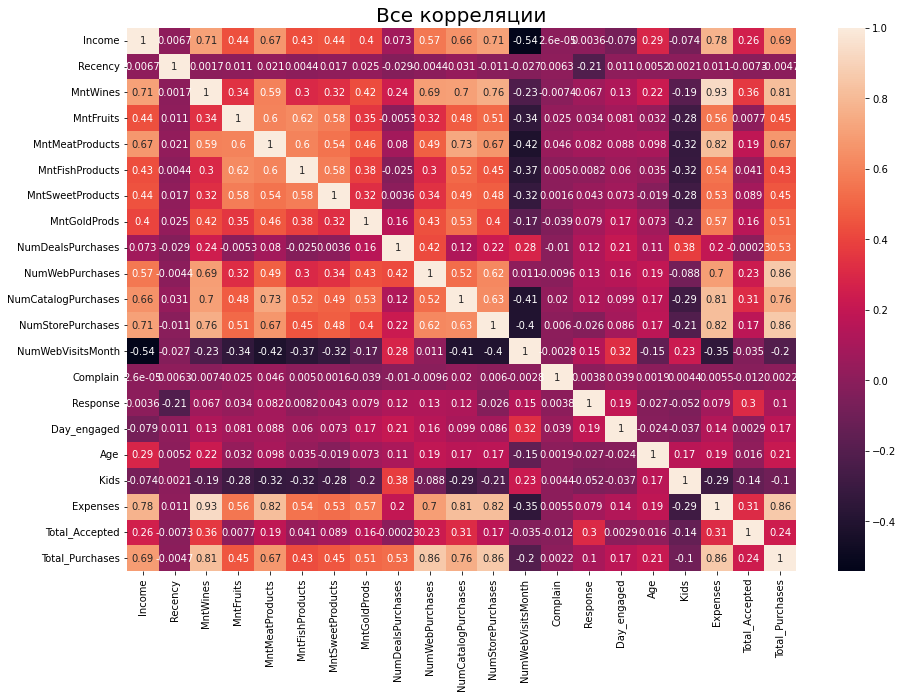

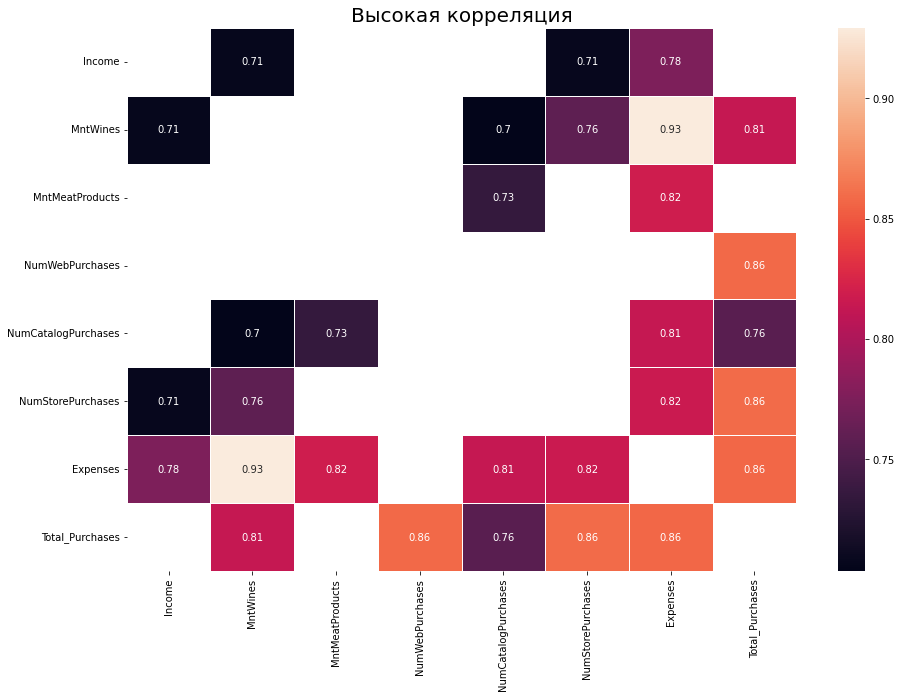

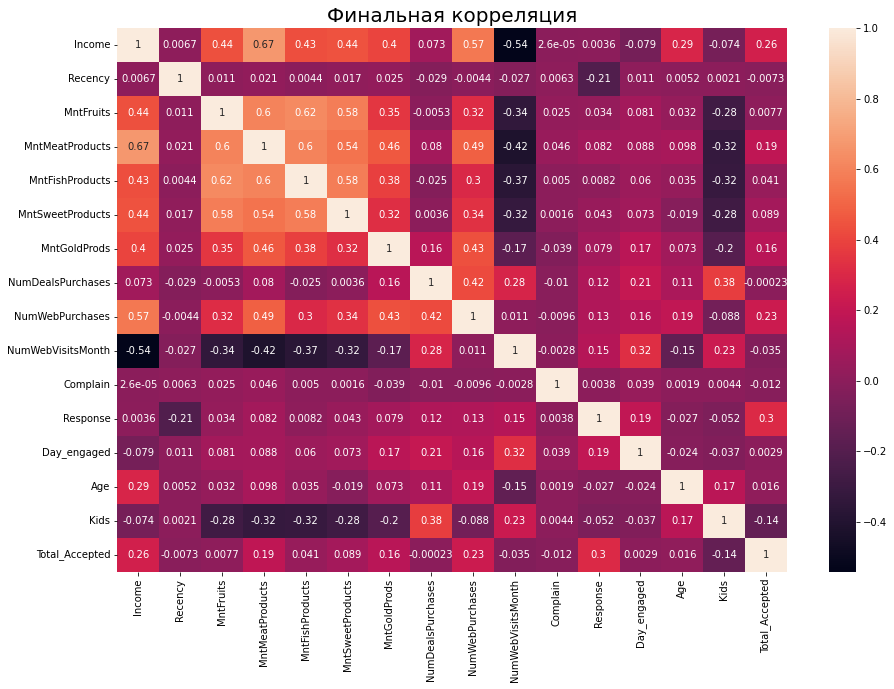

In [3]:
# preprocessing

'''
Вычислим сводную статистику по столбцам
'''

col_for_stat = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Age',
                'NumWebVisitsMonth', 'Expenses', 'Total_Accepted', 'Total_Purchases']
num_col = list(df.select_dtypes(['int64', 'float64', 'datetime64[ns]']).columns)
obj_col = list(df.select_dtypes(['object']).columns)

df[col_for_stat].describe().style.background_gradient(cmap='YlOrRd')


'''
Чистим выбросы (дописать)
'''
def count_outliers(df, col):
    out = []
    q1 = df[col].quantile(0.25, interpolation = 'nearest')
    q3 = df[col].quantile(0.75, interpolation = 'nearest')
    IQR = q3 - q1
    minimum = q1 - 1.5*IQR
    maximum = q3 + 1.5*IQR
    for elem in df[col]:
        if elem < minimum or elem > maximum:
            out.append(df.loc[df[col]==elem].index[0])
    df.drop(labels = out, axis = 0, inplace = True)

for x in col_for_stat:
    count_outliers(df, x)

df.shape


'''
удаление корреляций
'''

def delete_corr(df, cut_off = 0.7, exclude = []):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    f, ax = plt.subplots(figsize=(15, 10))
    plt.title('Все корреляции', fontsize=20)
    sns.heatmap(df.corr(), annot=True)

    try:
        f, ax = plt.subplots(figsize=(15, 10))
        plt.title('Высокая корреляция', fontsize=20)
        sns.heatmap(corr_matrix[(corr_matrix>cut_off) & (corr_matrix!=1)].dropna(axis=0, how='all').dropna(axis=1, how='all'), annot=True, linewidths=.5)
    except:
        print ('Нет признаков с высокой коррлеляцией')

    to_drop = [column for column in upper.columns if any(upper[column]>cut_off)]
    to_drop = [column for column in to_drop if column not in exclude]
    print('Удаленные признаки:', to_drop, '\n')
    df2 = df.drop(to_drop, axis = 1)

    f, ax = plt.subplots(figsize=(15, 10))
    plt.title('Финальная корреляция', fontsize = 20)
    sns.heatmap(df2.corr(), annot=True)
    plt.show()
    return df2

delete_corr(df)


'''
Визуализация и анализ
'''

df['Age_cut'] = pd.qcut(df['Age'], q=5)
df.groupby('Age_cut').agg({'Response' : ['mean','count']})

df.groupby('Education').agg({'Response' : ['mean','count']})

df.groupby('Living_Status').agg({'Response' : ['mean','count']})

df['Visits_cut'] = pd.qcut(df['NumWebVisitsMonth'], q=4)
df.groupby('Visits_cut').agg({'Response' : ['mean','count']})



'''
Кодирование и стандартизация
'''

LE=LabelEncoder()
for i in obj_col:
    df[i]=df[[i]].apply(LE.fit_transform)
df['Day_engaged']=df[['Day_engaged']].apply(LE.fit_transform)

del_cols = ['Age_cut', 'Visits_cut']
df.drop(del_cols, axis = 1, inplace = True)
X = df.drop('Response', axis = 1)
y = df['Response']

scaler = StandardScaler()
scaler.fit(X)
scaled_X = pd.DataFrame(scaler.transform(X),columns= X.columns)

In [4]:
from isodata import isodata_classification
import help_funcs as hf

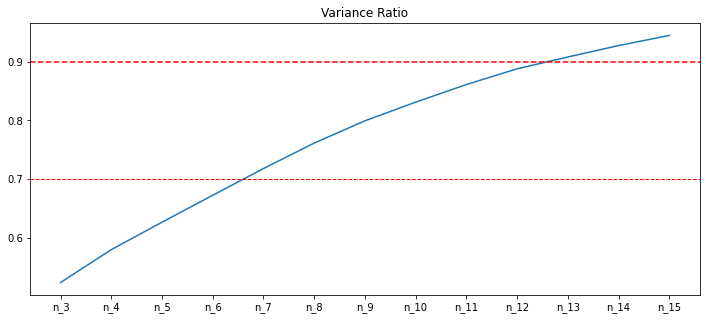

[0.35584748 0.10070646 0.06674578 0.05607474 0.04688337 0.04599524
 0.04561922 0.04343382 0.03798826 0.03185244 0.03011076 0.02681213]
[7.83351909 2.21692157 1.46932145 1.23441232 1.03207631 1.01252537
 1.00424771 0.95613908 0.83626209 0.7011901  0.66284924 0.59023414]


(1607, 12)

In [5]:
from sklearn.decomposition import PCA


'''
Уменьшение размерности
'''

variance_ratio = {}
for i in range(3, 16):
    pca = PCA(n_components=i)
    pca.fit(scaled_X)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
variance_ratio


plt.figure(figsize = (12, 5))
plt.plot([key for key in variance_ratio.keys()], [val for val in variance_ratio.values()])
plt.axhline(0.7, color = 'red', ls = '--', lw = 1)
plt.axhline(0.9, color = 'red', ls = '--', lw = 1.5)
plt.title("Variance Ratio")
plt.show()

#видим, что 8 признаков объясняют 70% дисперсии, а 90% - 12 признаков

pca = PCA(n_components=12)
pca.fit(scaled_X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
X_PCA = pca.transform(scaled_X)
X_PCA.shape

In [6]:
import random
random.seed(7)
np.random.seed(7)


data = np.array(X_PCA)
params = {"K": 4, "I" : 100, "P" : 2, "THETA_M" : 2, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.05}

# run ISODATA
obj_class, centers = isodata_classification(data, parameters=params)

Isodata(info): Starting algorithm with 4 classes
Given 1607 objects with 12 features
Chosen initial 4 centers: 
[[-2.28703403  0.30905295 -1.2930001  -0.23785408 -1.29899858 -0.00597005
   0.52957857 -0.56555808 -0.80745784  0.21142916  0.28588942 -0.47228905]
 [ 5.93950767  2.01190637 -1.77873167  1.16215887  1.06026583 -0.64988857
  -0.12343367 -0.85778612 -0.03291337 -0.5359045  -1.13886085 -0.83897574]
 [-2.76802428 -0.92307169 -1.19906727 -1.3892628   1.20537691  0.68001882
  -0.87411662  0.59307864 -0.27678916  1.05038564 -0.41058718 -0.35414724]
 [-2.03704794 -0.90248885  0.09447489 -0.74826271 -0.39836499 -0.01261757
   0.18165438 -1.31624119  0.25178024  0.25069614 -0.24161153 -0.7027465 ]]
Isodata(info): Finished with 4 classes
Isodata(info): Number of Iterations: 16


In [7]:
df["Clusters"] = obj_class + 1

In [8]:
import plotly.graph_objects as go

labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
cluster0_num = df[df["Clusters"]==1].shape[0]
cluster1_num = df[df["Clusters"]==2].shape[0]
cluster2_num = df[df["Clusters"]==3].shape[0]
cluster3_num = df[df["Clusters"]==4].shape[0]
values = [cluster0_num, cluster1_num, cluster2_num, cluster3_num]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.6, title="Clusters")])
fig.show()

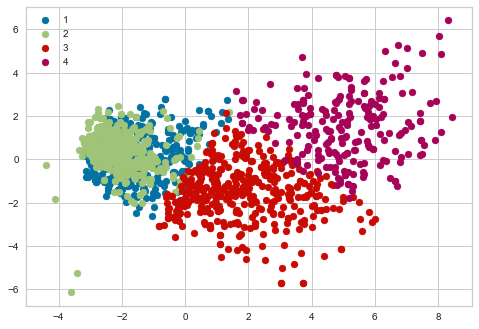

In [13]:
u_labels = np.unique(obj_class)
for i in u_labels:
    plt.scatter(X_PCA[obj_class == i , 0] , X_PCA[obj_class == i , 1] , label = i+1)

plt.legend()
plt.show()

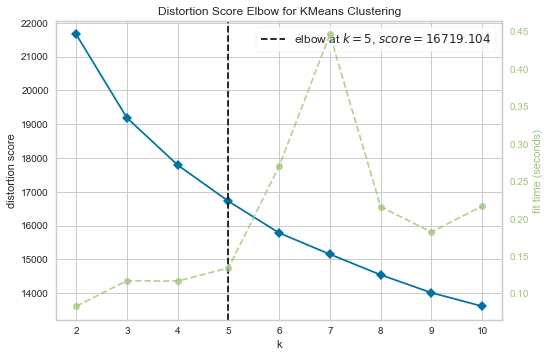

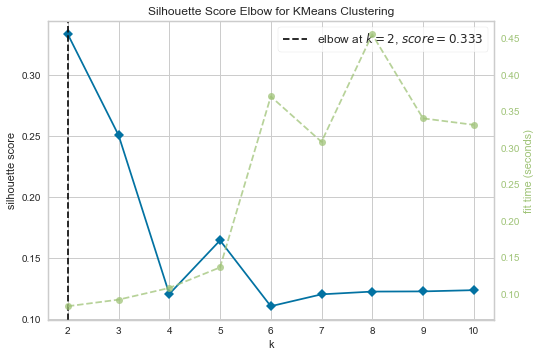

Для числа кластеров равное 3, оценка силуэта = 0.2508467552887201)
Для числа кластеров равное 4, оценка силуэта = 0.2607613296761626)
Для числа кластеров равное 5, оценка силуэта = 0.12691301045190076)
Для числа кластеров равное 6, оценка силуэта = 0.12202002371940796)
Для числа кластеров равное 7, оценка силуэта = 0.11707773956138284)
Для числа кластеров равное 8, оценка силуэта = 0.11746506854094926)
Для числа кластеров равное 9, оценка силуэта = 0.11974531574394111)


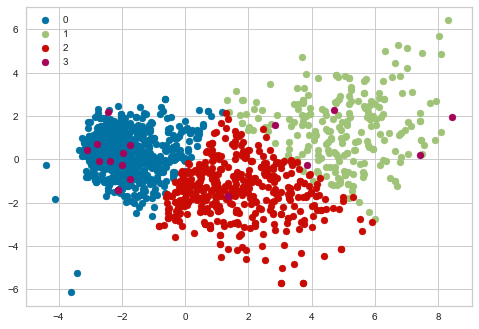

In [11]:
# clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objects as go


'''
Поиск числа кластеров
'''

km = KMeans()
elbow = KElbowVisualizer(estimator = km, k = 10)
elbow.fit(X_PCA)
elbow.show()
#Лучший K по методу локтя равен 4, попробуем метод силуэта.

elbow = KElbowVisualizer(estimator = km, k = 10, metric='silhouette')
elbow.fit(X_PCA)
elbow.show()
#Обычно рекомендуется выбирать номер K со вторым по величине показателем силуэта, поэтому оптимальное число кластеров K = 4

range_n_clusters = list(range(3, 10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    preds = clusterer.fit_predict(X_PCA)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_PCA, preds)
    print("Для числа кластеров равное {}, оценка силуэта = {})".format(n_clusters, score))

# изобразим графически полученный результат
kmeans = KMeans(n_clusters= 4)
label = kmeans.fit_predict(X_PCA)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(X_PCA[label == i , 0] , X_PCA[label == i , 1] , label = i)
plt.legend()
plt.show()

'''
Подтвердили, что оптимальное число кластеров - 5
'''

kmeans = KMeans(n_clusters=4, random_state=10)
predictions = kmeans.fit_predict(X_PCA)
df["Clusters"] = predictions + 1


labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
cluster0_num = df[df["Clusters"]==1].shape[0]
cluster1_num = df[df["Clusters"]==2].shape[0]
cluster2_num = df[df["Clusters"]==3].shape[0]
cluster3_num = df[df["Clusters"]==4].shape[0]
values = [cluster0_num, cluster1_num, cluster2_num, cluster3_num]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.6, title="Clusters")])
fig.show()

In [12]:
# training

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


db = DBSCAN(eps=0.726, min_samples=26)
db.fit(X_PCA)
clusters = db.labels_
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)
print("Число кластеров: %d" % n_clusters_)
print("Число шумовых значений: %d" % n_noise_)
print('Количество точек на кластер:')
for i in range(n_clusters_):
    print('Кластер', i, ':', len(clusters[clusters==i]))

Число кластеров: 0
Число шумовых значений: 1607
Количество точек на кластер:
